In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [7]:
data = get_data(224, bs, 'zeros')

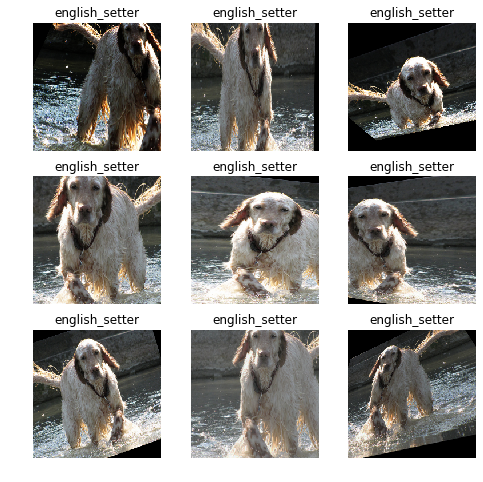

In [8]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [9]:
data = get_data(224,bs)

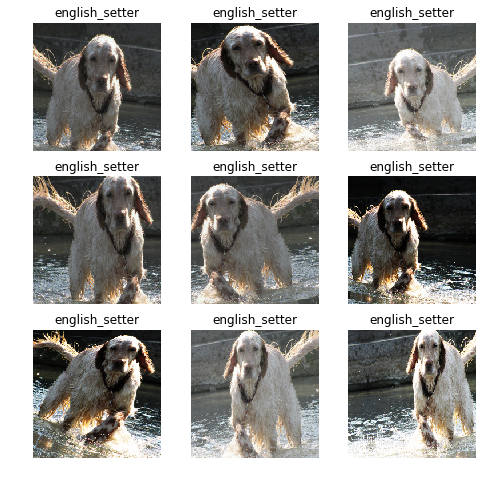

In [10]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [11]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [12]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.415038,1.170708,0.267930,01:08
1,1.424222,0.391572,0.098782,00:44
2,0.882192,0.328398,0.091340,00:45


In [13]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.676787,0.322162,0.075778,00:46
1,0.646191,0.315253,0.071042,00:46


In [14]:
data = get_data(352,bs)
learn.data = data

In [15]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.608303,0.301104,0.068336,01:30
1,0.582907,0.293646,0.064276,01:29


In [17]:
learn.save('learner')

# HeatMap

In [18]:
data = get_data(352,16)

In [19]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('learner')

In [20]:
m = learn.model.eval();

Category pomeranian

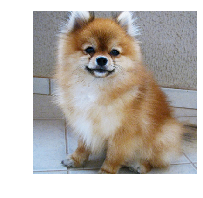

In [22]:
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [25]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [26]:
from fastai.callbacks.hooks import *

In [27]:
with hook_output(m[0]) as hook_a: m(xb)

In [31]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [32]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

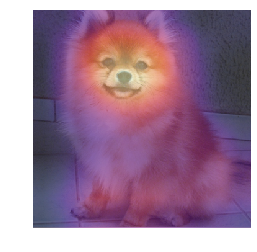

In [33]:
_, ax = plt.subplots()
xb_im.show(ax)
ax.imshow(avg_acts, alpha=0.6, extent=(0,352,352,0),interpolation='bilinear',cmap='magma')